In [1]:
import pandas as pd
import numpy as np
import sys,os
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Ellipse
import seaborn as sns
%matplotlib inline 
sns.set_style('darkgrid')

# for plot
def plot_point_cov(points, nstd=3, ax=None, **kwargs):
    # 求所有点的均值作为置信圆的圆心
    pos = points.mean(axis=0)
    # 求协方差
    cov = np.cov(points, rowvar=False)
 
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=3, ax=None, **kwargs):
    def eigsorted(cov):
        cov = np.array(cov)
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]
    if ax is None:
        ax = plt.gca()
    vals, vecs = eigsorted(cov)
 
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellip)
    
    return ellip,pos

In [2]:
#############
# get data
#############
cell = 'MCF7'
fold = 2
data_dir = '/home/jlk/Project/111_Cmap/MOA/'
data_info_dir = '{}/data/01_Info_file/'.format(data_dir)
data_all_dir = '{}/data/02_All_data/'.format(data_dir)
data_cell_dir = '{}/data/03_Single_Cell/'.format(data_dir)
sig2drugmoa_file = '{}/sig2drugmoa.npz'.format(data_info_dir)
drug2moa_file = '{}/drug2moa.npz'.format(data_info_dir)

###############
# train data
#
train_file = '{}/{}/Train_fold_{}.h5'.format(data_cell_dir,cell,fold)
test_file = '{}/{}/Test_fold_{}.h5'.format(data_cell_dir,cell,fold)

sig2drugmoa_dict = np.load(sig2drugmoa_file)
drug2moa_dict = np.load(drug2moa_file)
train_df = pd.read_hdf(train_file)
test_df = pd.read_hdf(test_file)
print('Train & Test before train',train_df.shape,test_df.shape)

###############
# embedding data
#
train_embedding_file = '{}/src/result_demention/train_embedding.h5'.format(data_dir)
test_embedding_file = '{}/src/result_demention/test_embedding.h5'.format(data_dir)
train_embedding_df = pd.read_hdf(train_embedding_file)
test_embedding_df = pd.read_hdf(test_embedding_file)
print('Train & Test Embedding data',train_embedding_df.shape,test_embedding_df.shape)


Train & Test before train (2931, 12328) (1818, 12328)
Train & Test Embedding data (2931, 256) (1818, 256)


In [3]:
#############
# stat moa
#############
moas = ['HDAC-i','HSP-i','MEK/ERK-i','PKC-activator','Topo-i','antimetabolite','antimicrotubule',
        'retinoid','proteasome inh.','mTOR-i']
moa_dict = {'HDAC-i':1,'HSP-i':2,'MEK/ERK-i':3,'PKC-activator':4,'Topo-i':5,'antimetabolite':6,'antimicrotubule':7,
        'retinoid':8,'proteasome inh.':9,'mTOR-i':10}

train_sigs = train_df.index
train_moas = [sig2drugmoa_dict[i][1] for i in train_sigs]
moa_counts = Counter(train_moas)
# print('### There are {} moas!'.format(len(moa_counts)))

for moa in moas:
    print(moa,moa_counts[moa])


HDAC-i 232
HSP-i 100
MEK/ERK-i 121
PKC-activator 19
Topo-i 192
antimetabolite 66
antimicrotubule 83
retinoid 73
proteasome inh. 379
mTOR-i 156


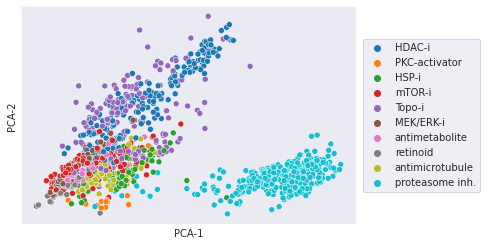

In [4]:
##################
# before train data
##################
plot_train_index = np.where(np.isin(train_moas,moas),True,False)
plot_train_data = train_df.loc[plot_train_index]

plot_train_x = plot_train_data.values
plot_train_y = [sig2drugmoa_dict[i][1] for i in plot_train_data.index]
plot_train_y = np.array(plot_train_y)

#################
# before train plot PCA
#################
X_PCA = PCA(n_components=2).fit_transform(plot_train_x)

df = pd.DataFrame(X_PCA)
df.columns = ['x','y']
df['l'] = plot_train_y
sns.scatterplot(data=df,x='x',y='y',hue='l')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.legend(bbox_to_anchor=(1.005, 0.5), loc='center left')
plt.show()

In [5]:
##################
# before train plot TSNE
##################
X_tsne_train = TSNE(n_components=2, random_state=1).fit_transform(plot_train_x)
print(X_tsne_train.shape,plot_train_y.shape)

##################
# after train Embedding
##################
train_emb_index_moa = [i.split('_')[0] for i in train_embedding_df.index]
train_moa_index = np.where(np.isin(train_emb_index_moa,moas),True,False)
train_emb_data = train_embedding_df.loc[train_moa_index]
train_emb_moa = [i.split('_')[0] for i in train_emb_data.index] 
train_emb_y = np.array(train_emb_moa)
X_tsne_train_emb = TSNE(n_components=2, random_state=1).fit_transform(train_emb_data)
print(X_tsne_train_emb.shape,train_emb_y.shape)

##################
# test Embedding
##################
drug_moa = {'HDAC-i':'BRD-K02130563','HSP-i':'BRD-K41859756',
            'MEK/ERK-i':'BRD-K49865102','PKC-activator':'BRD-K68552125',
            'Topo-i':'BRD-A35588707','antimetabolite':'BRD-K15108141',
            'antimicrotubule':'BRD-A28746609','retinoid':'BRD-K25737009',
            'proteasome inh.':'BRD-K60230970','mTOR-i':'BRD-K94294671'}

drugs = ['BRD-K41859756','BRD-K02130563','BRD-K49865102','BRD-K68552125',
         'BRD-A35588707','BRD-K15108141','BRD-A28746609','BRD-K60230970',
         'BRD-K25737009','BRD-K94294671']
test_emb_index_drug = [i.split('_')[1] for i in test_embedding_df.index]
test_drug_index = np.where(np.isin(test_emb_index_drug,drugs),True,False)
test_emb_data = test_embedding_df.loc[test_drug_index]
test_drug = [i.split('_')[1] for i in test_emb_data.index] 

##################
#### Train and Test
##################
plot_train_test_x = pd.concat([train_emb_data,test_emb_data]).values
plot_train_test_y = np.array(train_emb_moa + test_drug)
final_X_tsne = TSNE(n_components=2, random_state=1).fit_transform(plot_train_test_x)
print(final_X_tsne.shape,plot_train_test_y.shape)

(1421, 2) (1421,)
(1421, 2) (1421,)
(2024, 2) (2024,)


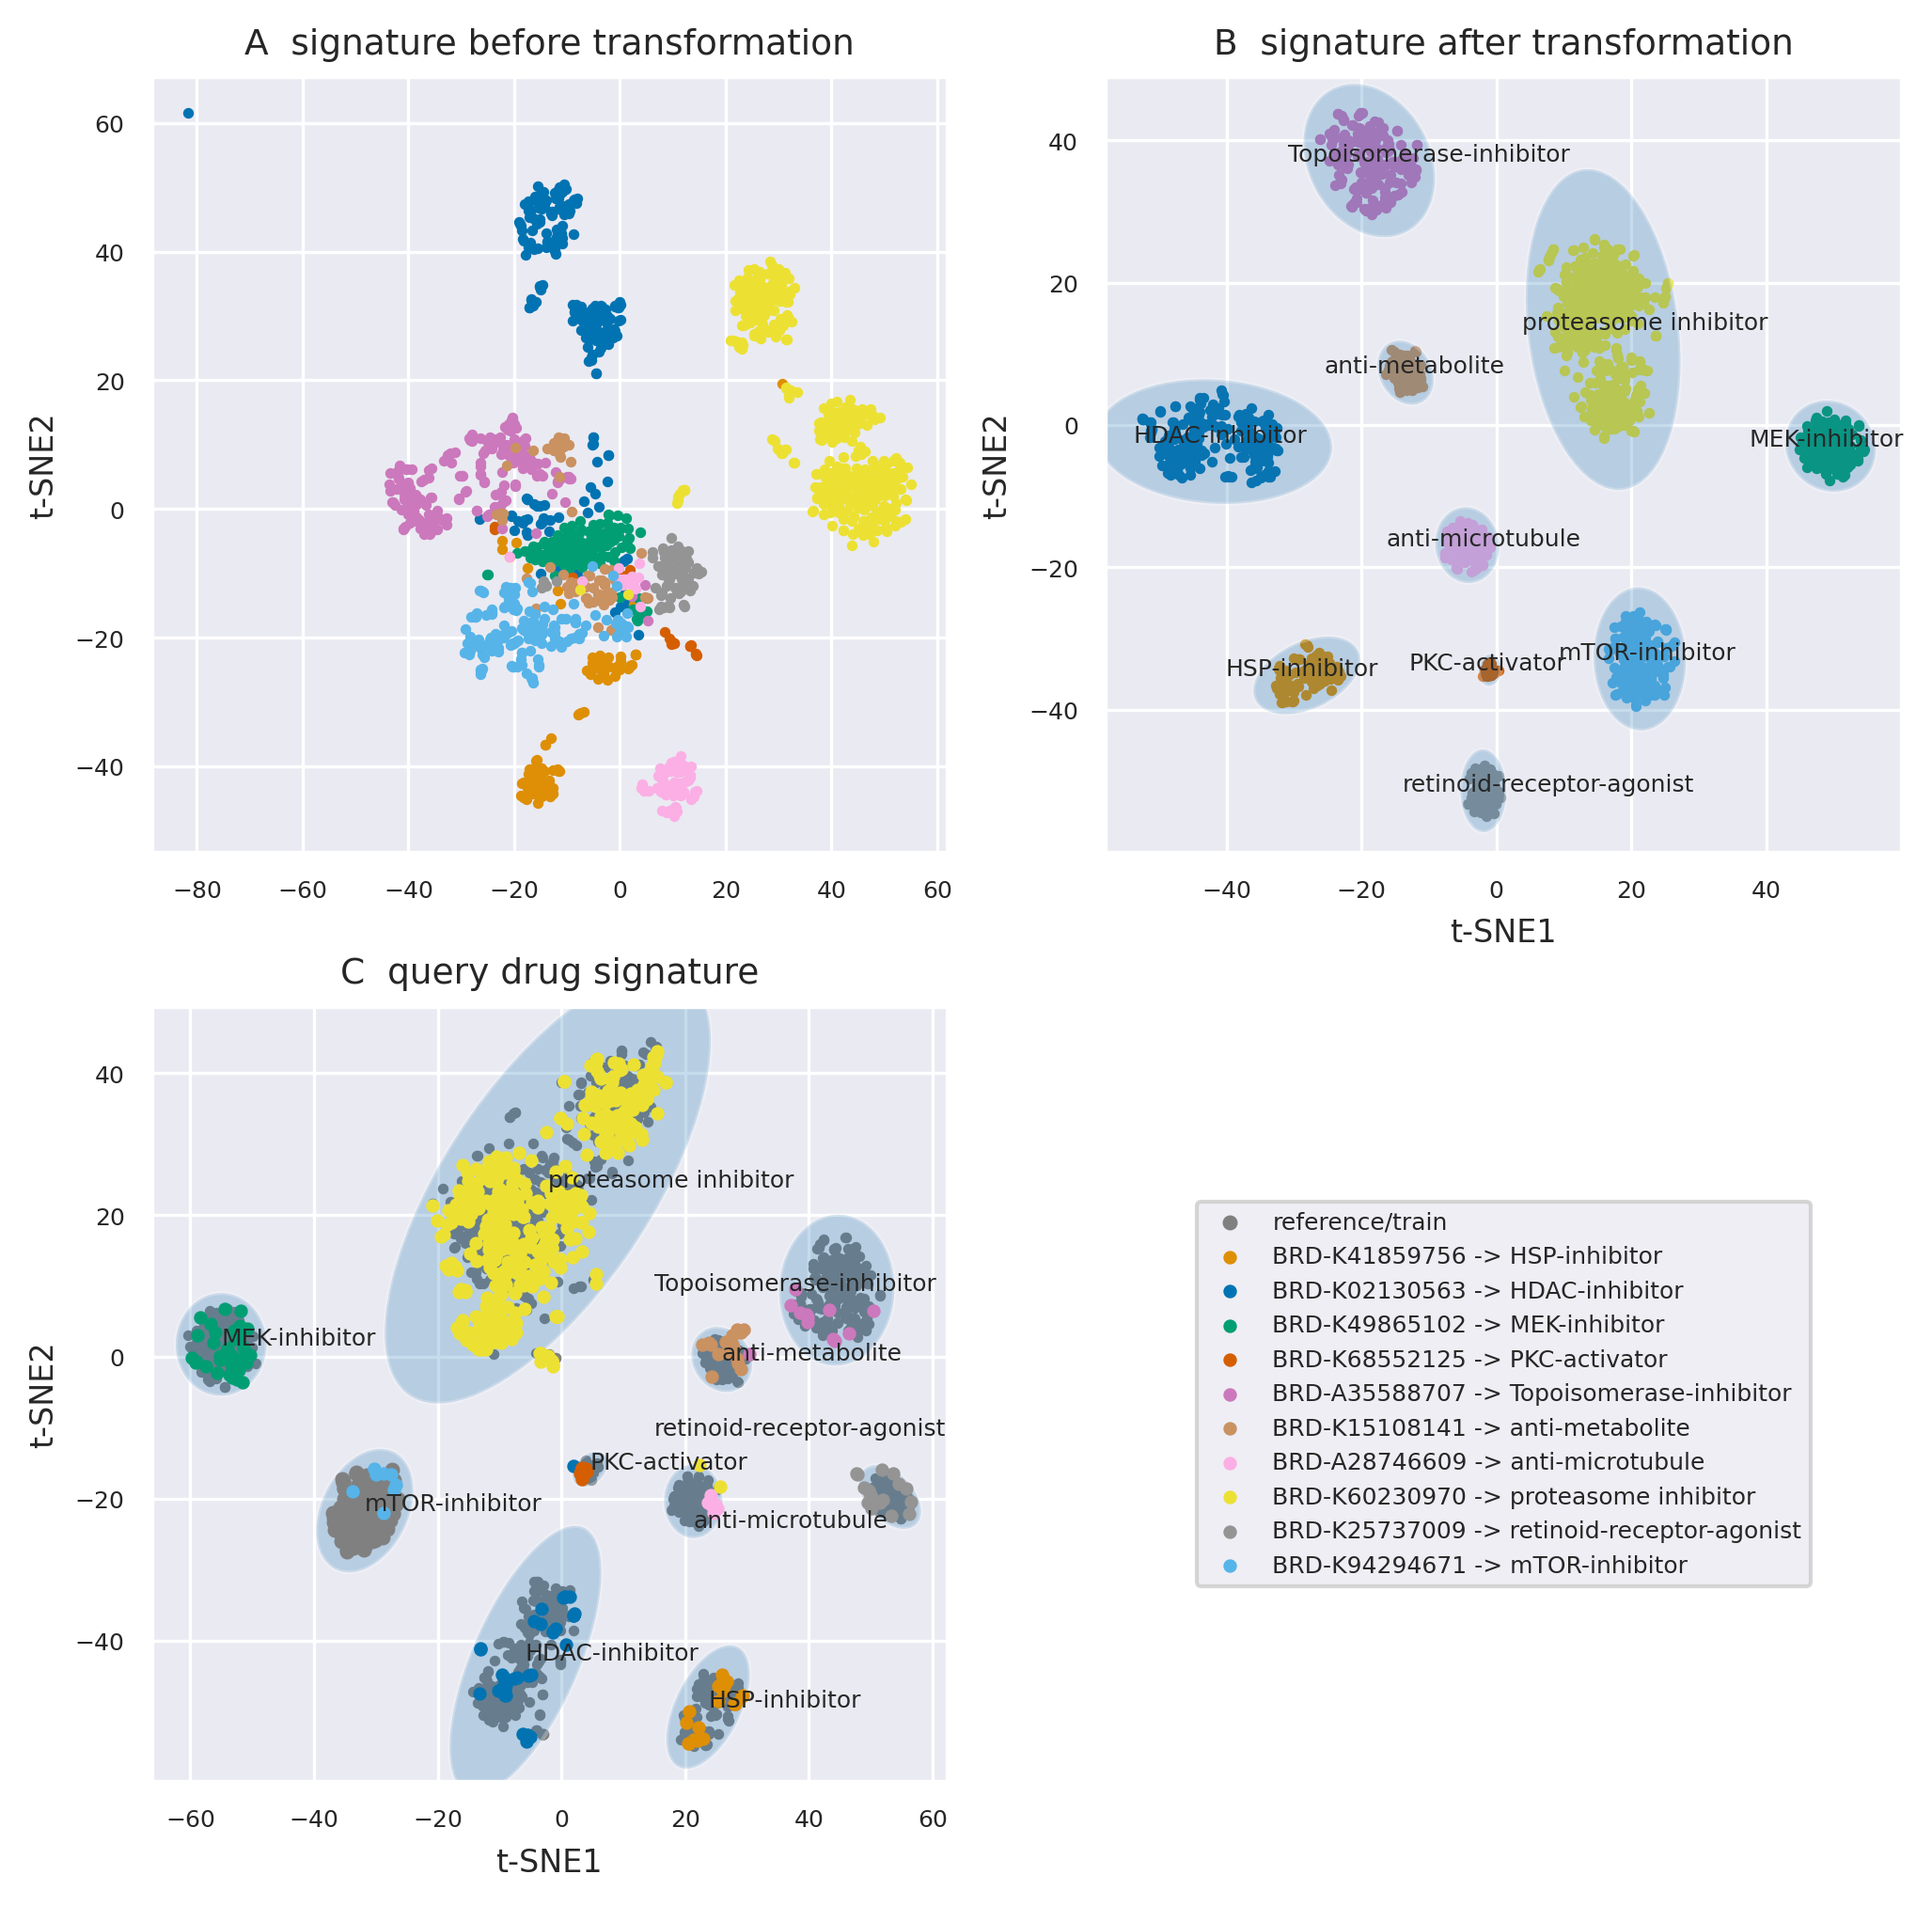

In [6]:
name_dict = {"HDAC-i":"HDAC-inhibitor",
             "HSP-i":"HSP-inhibitor",
             "MEK/ERK-i":"MEK-inhibitor",
             "PKC-activator":"PKC-activator",
             "Topo-i":"Topoisomerase-inhibitor",
             "antimetabolite":"anti-metabolite",
             "antimicrotubule":"anti-microtubule",
             "retinoid":"retinoid-receptor-agonist",
             "proteasome inh.":"proteasome inhibitor",
             "mTOR-i":"mTOR-inhibitor"}
drug_moa_dict = dict([val, key] for key, val in drug_moa.items())
col_map = {}
col_pal = sns.color_palette("muted")
col_pal = sns.color_palette("colorblind")

for n in range(len(moas)):
    moa = moas[n]
    col_map[moa] = col_pal[n]

my_dpi=300
plt.figure(figsize=(8,8),dpi=my_dpi)
# fig.tight_layout(h_pad=2)

##################
# before train
plt.subplot(221)
X_tsne = X_tsne_train
y = plot_train_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i] )
plt.title('A  signature before transformation',fontsize=9)
# plt.xticks([],[])
# plt.yticks([],[])
# plt.xlabel('t-SNE1',fontsize=6)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# after train
plt.subplot(222)
X_tsne = X_tsne_train_emb
y = train_emb_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i])
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    plt.text(pos[0]-12, pos[1], name_dict[i], fontsize=6)

plt.title('B  signature after transformation',fontsize=9)
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 

##################
# train and test drug
plt.subplot(223)
X_tsne = final_X_tsne
y = plot_train_test_y

for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label='_nolegend_',color='grey')
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    pos0 = pos[0]
    pos1 = pos[1]

    if i == 'retinoid':
        pos0 = 15
        pos1 = -11
    if i == 'Topo-i':
        pos0 = 15
    if i == 'antimicrotubule':
        pos1 = -24
    plt.text(pos0, pos1, name_dict[i], fontsize=6)

tr_moa_idx = np.where(np.isin(y,moa),True,False)
plt.scatter(X_tsne[tr_moa_idx,0],X_tsne[tr_moa_idx,1],s=8,label = 'reference/train',color='grey')

    
for i in drugs:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=6,label = i+' -> '+name_dict[drug_moa_dict[i]],
                color = col_map[drug_moa_dict[i]])
plt.title('C  query drug signature',fontsize=9)
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=8)
plt.ylabel('t-SNE2',fontsize=8)
plt.tick_params(labelsize=6) 
plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center left',fontsize=6)



# plt.show()
plt.savefig('Demention.jpg')

<ipython-input-46-25fb75bccd16>:117: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


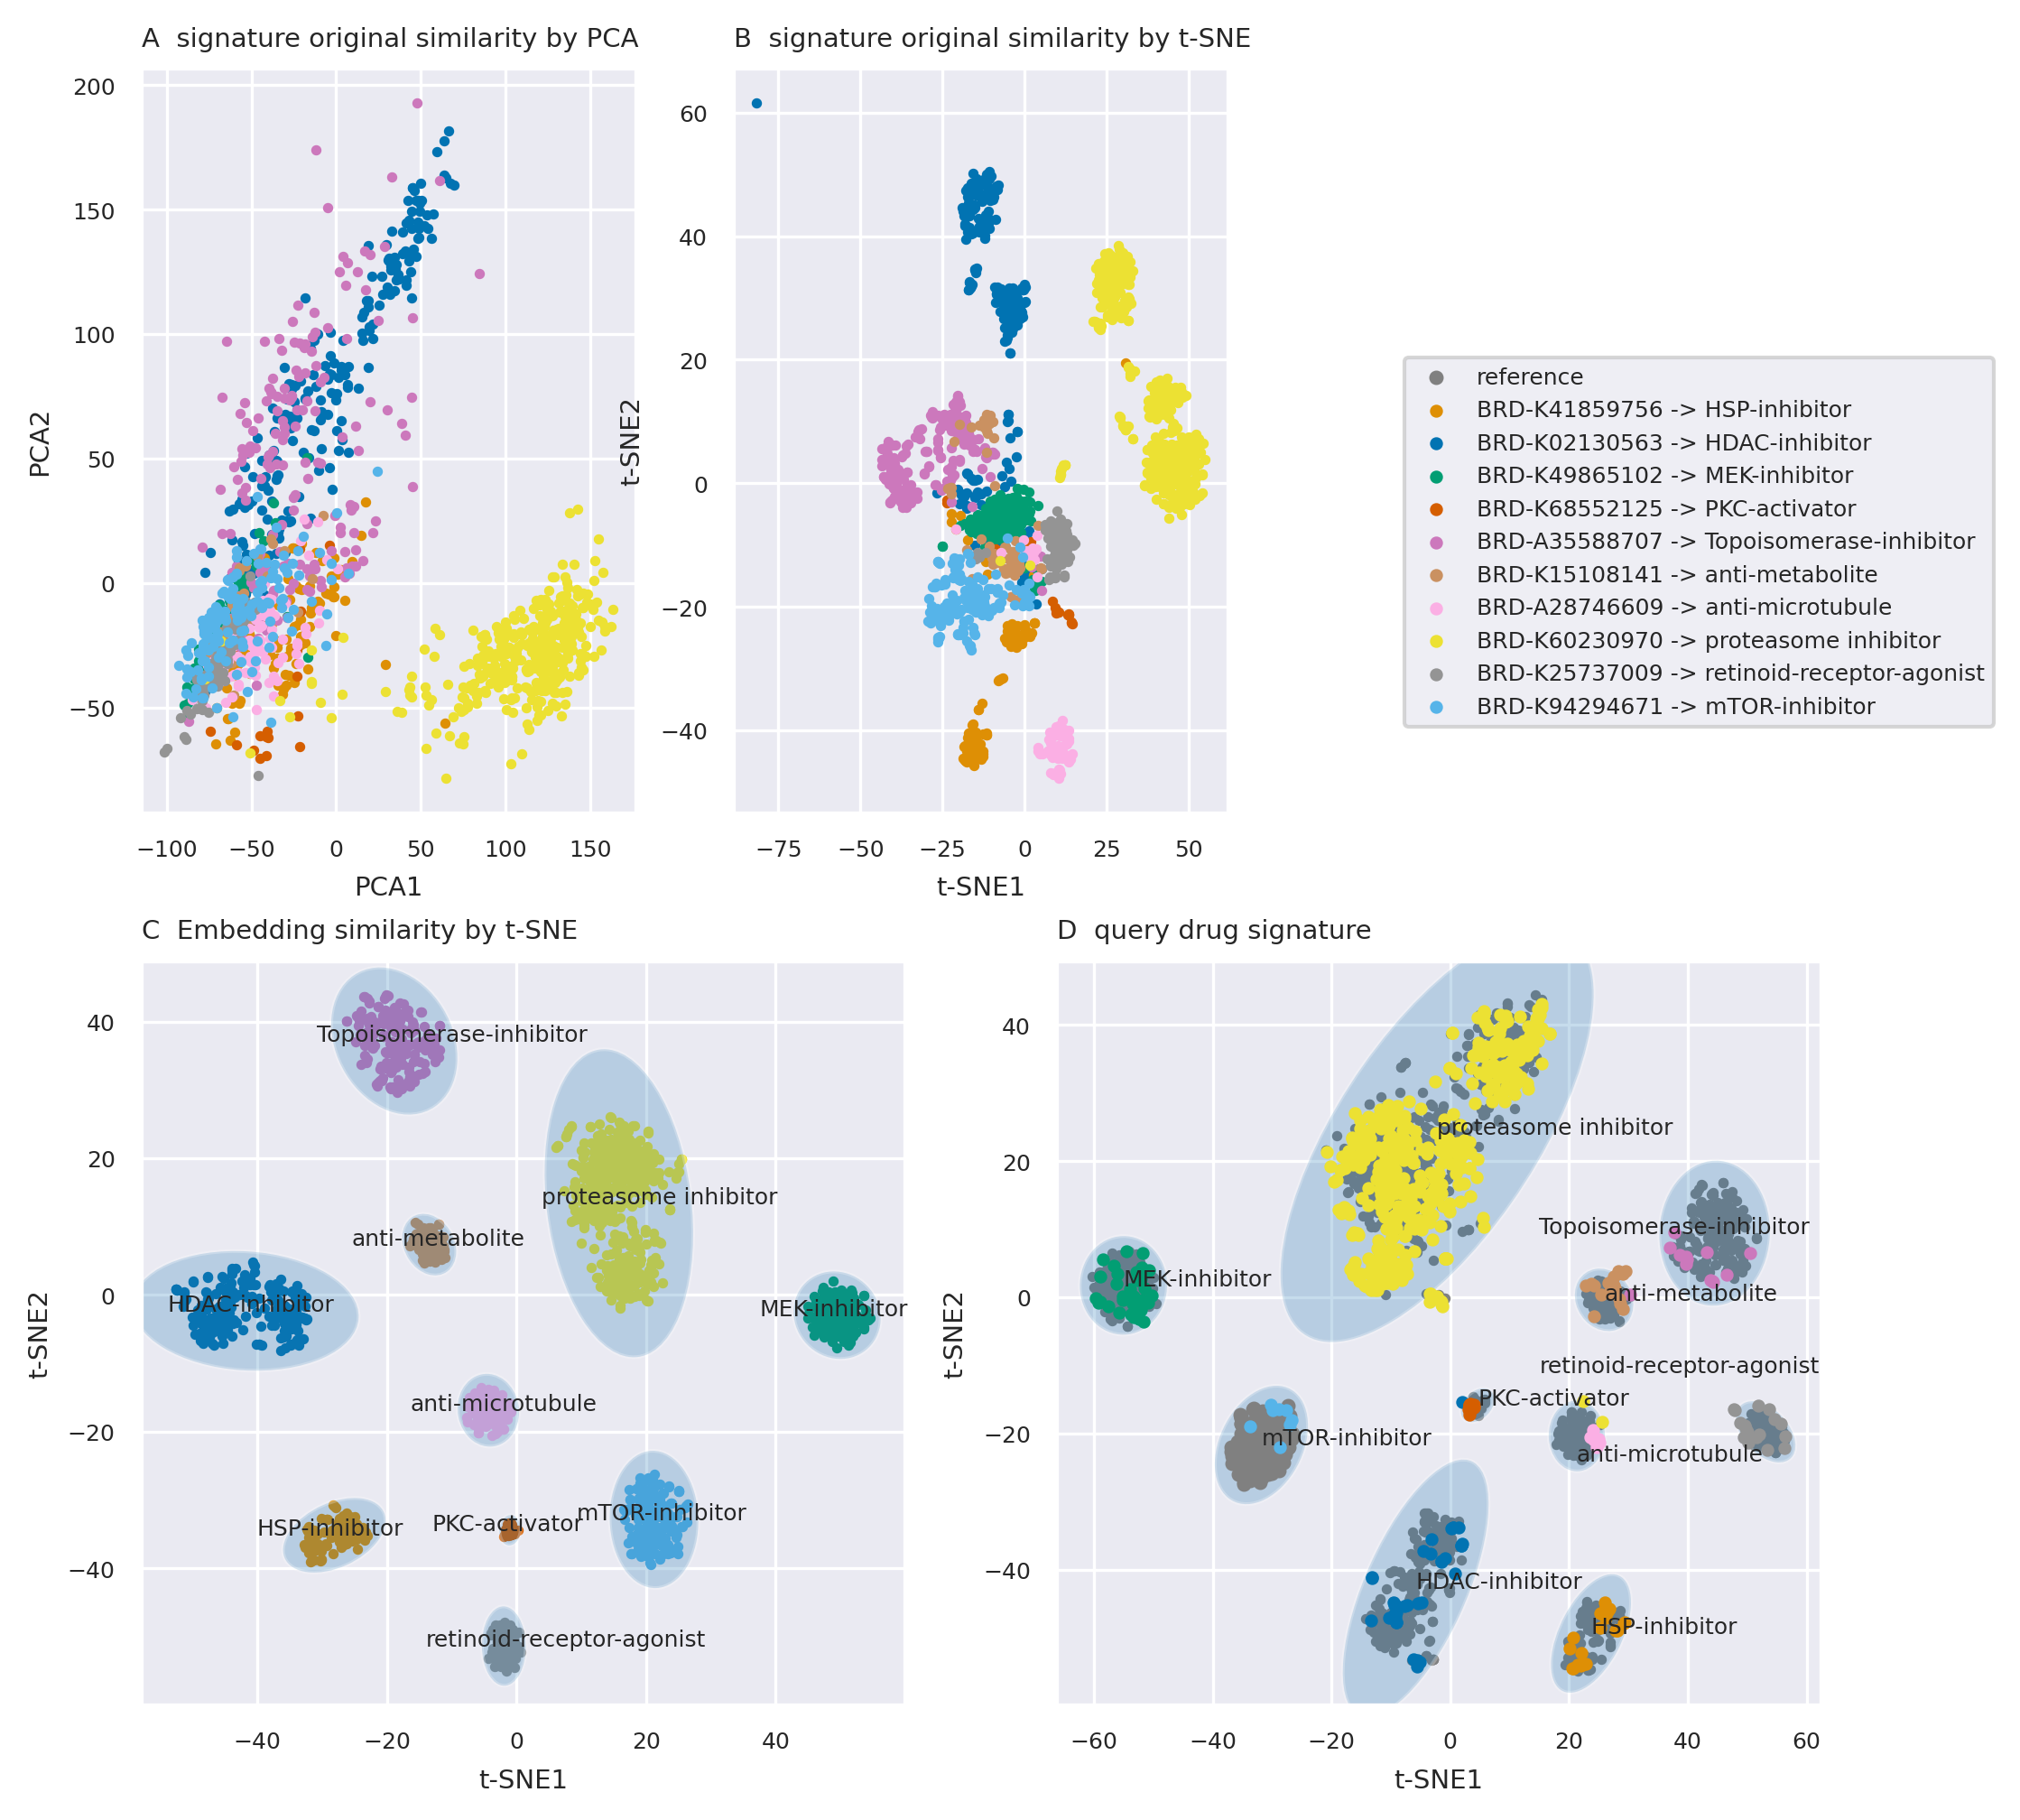

In [46]:
name_dict = {"HDAC-i":"HDAC-inhibitor",
             "HSP-i":"HSP-inhibitor",
             "MEK/ERK-i":"MEK-inhibitor",
             "PKC-activator":"PKC-activator",
             "Topo-i":"Topoisomerase-inhibitor",
             "antimetabolite":"anti-metabolite",
             "antimicrotubule":"anti-microtubule",
             "retinoid":"retinoid-receptor-agonist",
             "proteasome inh.":"proteasome inhibitor",
             "mTOR-i":"mTOR-inhibitor"}
drug_moa_dict = dict([val, key] for key, val in drug_moa.items())
col_map = {}
col_pal = sns.color_palette("muted")
col_pal = sns.color_palette("colorblind")

for n in range(len(moas)):
    moa = moas[n]
    col_map[moa] = col_pal[n]

my_dpi=300
plt.figure(figsize=(8,8),dpi=my_dpi)
# fig.tight_layout(h_pad=2)

#################
# before train plot PCA
#################
plt.subplot(2,3,1)
y = plot_train_y

for i in moas:
    plt.scatter(X_PCA[y==i,0],X_PCA[y==i,1],s=3,label = i,color=col_map[i] )
plt.title('A  signature original similarity by PCA',fontsize=7,loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('PCA1',fontsize=7)
plt.ylabel('PCA2',fontsize=7)

plt.tick_params(labelsize=6) 


##################
# before train t-SNE
plt.subplot(2,3,2)
X_tsne = X_tsne_train
y = plot_train_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i] )
plt.title('B  signature original similarity by t-SNE',fontsize=7,loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)
plt.tick_params(labelsize=6) 

##################
# after train
plt.subplot(2,2,3)
X_tsne = X_tsne_train_emb
y = train_emb_y


for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label = i,color=col_map[i])
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    plt.text(pos[0]-12, pos[1], name_dict[i], fontsize=6)

plt.title('C  Embedding similarity by t-SNE',fontsize=7,loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)
plt.tick_params(labelsize=6) 

##################
# train and test drug
plt.subplot(2,2,4)
X_tsne = final_X_tsne
y = plot_train_test_y

for i in moas:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=3,label='_nolegend_',color='grey')
    _,pos = plot_point_cov(X_tsne[y==i,:], nstd=3, alpha=0.25)
    pos0 = pos[0]
    pos1 = pos[1]

    if i == 'retinoid':
        pos0 = 15
        pos1 = -11
    if i == 'Topo-i':
        pos0 = 15
    if i == 'antimicrotubule':
        pos1 = -24
    plt.text(pos0, pos1, name_dict[i], fontsize=6)

tr_moa_idx = np.where(np.isin(y,moa),True,False)


plt.scatter(X_tsne[tr_moa_idx,0],X_tsne[tr_moa_idx,1],s=8,label = 'reference',color='grey')


# plt.subplot(2,3,5)  
for i in drugs:
    plt.scatter(X_tsne[y==i,0],X_tsne[y==i,1],s=6,label = i+' -> '+name_dict[drug_moa_dict[i]],
                color = col_map[drug_moa_dict[i]])
plt.title('D  query drug signature',fontsize=7,loc='left')
# plt.xticks([],[])
# plt.yticks([],[])
plt.xlabel('t-SNE1',fontsize=7)
plt.ylabel('t-SNE2',fontsize=7)
plt.tick_params(labelsize=6) 
# plt.legend(bbox_to_anchor=(1.3, 0.5), loc='best',fontsize=6)
plt.legend(bbox_to_anchor=(0.44, 1.3), fontsize=6)


plt.tight_layout()

# plt.show()
plt.savefig('Figure3.jpg')

In [ ]:
import seaborn as sns
pallettes = ["deep", "muted", "pastel", "bright", "dark", "colorblind"]
data = np.array([sns.color_palette(pat) for pat in pallettes])
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(111)
# print(data)
ax.imshow(data)
for i, pat in enumerate(pallettes):
    ax.text(-0.6, i, pat, ha="right")
plt.axis("off");

col_map = {}
print(sns.color_palette("muted"))
col_dict = {"HDAC-i":"purple",
             "HSP-i":"green",
             "MEK/ERK-i":"pink",
             "PKC-activator":"brown",
             "Topo-i":"red",
             "antimetabolite":"teal",
             "antimicrotubule":"orange",
             "retinoid":"blue",
             "proteasome inh.":"yellow",
             "mTOR-i":"turquoise"}
col_pal = sns.color_palette("muted")
for n in range(len(moas)):
    moa = moas[n]
    col_map[moa] = col_pal 